# Video Classification and Contrastive Learning Experiments

This notebook performs experiments on video classification using C3D and R(2+1)D models. It includes baseline classification, multi-dataset supervised contrastive learning (MSupCL), and self-supervised contrastive learning (SSCL) using SimCLR framework.


## Setup and Data Preprocessing

### Import Libraries

In [1]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras import layers, models, losses, optimizers, metrics,callbacks
from tensorflow.python.keras.utils.version_utils import callbacks

from model_train import (
    load_c3d_model,
    load_c3d_sscl_model,
    train_msupcl_model,
    train_simclr_model,
    linear_evaluation,
    linear_evaluation_sscl,
)

from data_uniform_sup import VideoDataGenerator, MultiDatasetDataGenerator
from data_uniform_sscl import SSCLVideoDataGenerator


from model_train_r2plus1d_18 import (
    load_r2plus1d_model,
    load_sscl_r2plus1d_model,
)

### Set Random Seeds and Hyperparameters

In [2]:
# Set random seeds for reproducibility
seed = 2042
np.random.seed(seed)
random.seed(seed)
tf.random.set_seed(seed)

# Hyperparameters
input_shape = (12, 64, 64, 3)  # Input shape of the videos
num_classes = 2  # Number of classes: Harmful Content or Safe Content
feature_dim = 512
num_epochs = 10
batch_size = 4
temperature = 0.8
learning_rate = 0.00001
sample_size = 160

### Sample Videos from Datasets

In [3]:
# Define dataset paths
violence_negative_dir = './data/violence_dataset/NonViolence'
violence_positive_dir = './data/violence_dataset/Violence'
tiktok_negative_dir = './data/tiktok/train/Safe'
tiktok_positive_dir = './data/tiktok/train/Harmful Content'

violence_class_name = ['NonViolence', 'Violence']
tiktok_class_name = ['Safe', 'Harmful Content']

In [4]:
def sample_videos(directory, num_samples=100):
    """Sample videos from a directory."""
    all_videos = [
        os.path.join(directory, f)
        for f in os.listdir(directory)
        if f.endswith('.mp4')
    ]
    sampled_videos = random.sample(all_videos, min(num_samples, len(all_videos)))
    return sampled_videos


In [5]:
# Sample videos from each class
violence_negative_videos = sample_videos(violence_negative_dir, sample_size)
violence_positive_videos = sample_videos(violence_positive_dir, sample_size)
tiktok_negative_videos = sample_videos(tiktok_negative_dir, sample_size)
tiktok_positive_videos = sample_videos(tiktok_positive_dir, sample_size)

In [6]:
print(len(violence_negative_videos))

160


### Split Data into Train, Validation, and Test Sets

In [7]:
def split_data(negative_videos, positive_videos, train_ratio=0.55, val_ratio=0.15):
    """Split data into train, validation, and test sets."""
    # Combine and shuffle data
    videos = negative_videos + positive_videos
    labels = [0] * len(negative_videos) + [1] * len(positive_videos)
    combined = list(zip(videos, labels))
    random.shuffle(combined)
    videos[:], labels[:] = zip(*combined)

    # Compute split indices
    total = len(videos)
    train_end = int(total * train_ratio)
    val_end = train_end + int(total * val_ratio)

    # Split datasets
    train_videos = videos[:train_end]
    train_labels = labels[:train_end]
    val_videos = videos[train_end:val_end]
    val_labels = labels[train_end:val_end]
    test_videos = videos[val_end:]
    test_labels = labels[val_end:]

    return (train_videos, train_labels), (val_videos, val_labels), (test_videos, test_labels)


In [8]:
# Violence dataset
(violence_train_videos, violence_train_labels), (violence_val_videos, violence_val_labels), (violence_test_videos, violence_test_labels) = split_data(violence_negative_videos, violence_positive_videos)

# TikTok dataset
(tiktok_train_videos, tiktok_train_labels), (tiktok_val_videos, tiktok_val_labels), (tiktok_test_videos, tiktok_test_labels) = split_data(tiktok_negative_videos, tiktok_positive_videos)



In [9]:

# Convert labels to numpy arrays and one-hot encode them if necessary
def prepare_labels(labels):
    return np.array(labels)


# Prepare labels for both datasets
violence_train_labels_np = prepare_labels(violence_train_labels)
violence_val_labels_np = prepare_labels(violence_val_labels)
violence_test_labels_np = prepare_labels(violence_test_labels)

tiktok_train_labels_np = prepare_labels(tiktok_train_labels)
tiktok_val_labels_np = prepare_labels(tiktok_val_labels)
tiktok_test_labels_np = prepare_labels(tiktok_test_labels)

### Create Data Generators

In [10]:
violence_train_generator = VideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
)


In [ ]:
X_batch, y_batch = violence_train_generator[0]

In [12]:
# Find indices of positive and negative samples
positive_indices = np.where(y_batch == 1)[0]
negative_indices = np.where(y_batch == 0)[0]

positive_sample = None
negative_sample = None
# Ensure we have at least one positive and one negative sample
if len(positive_indices) == 0 or len(negative_indices) == 0:
    print("No positive or negative samples found in this batch.")
else:
    # Extract one positive and one negative sample
    positive_sample = X_batch[positive_indices[0]]  # Shape: (12, height, width, 3)
    negative_sample = X_batch[negative_indices[0]]  # Shape: (12, height, width, 3)

In [13]:
import cv2


def visualize_sample(sample, title):
    """Visualize the 12 frames of a video sample."""
    num_frames = sample.shape[0]
    cols = 4
    rows = num_frames // cols if num_frames % cols == 0 else (num_frames // cols) + 1
    plt.figure(figsize=(15, 5))
    for i in range(num_frames):
        frame = sample[i]
        # Convert BGR to RGB
        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, cols, i + 1)
        plt.imshow(frame_rgb)
        plt.axis('off')
    plt.suptitle(title)
    plt.show()

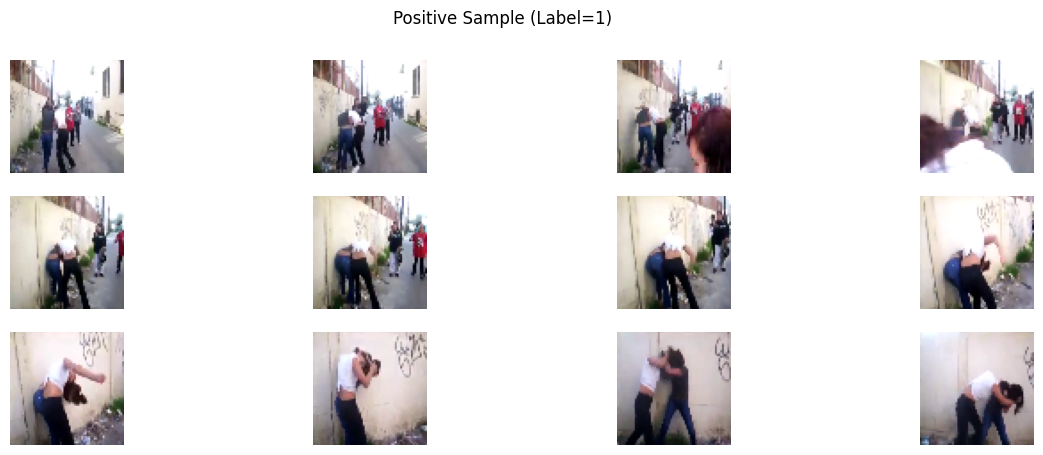

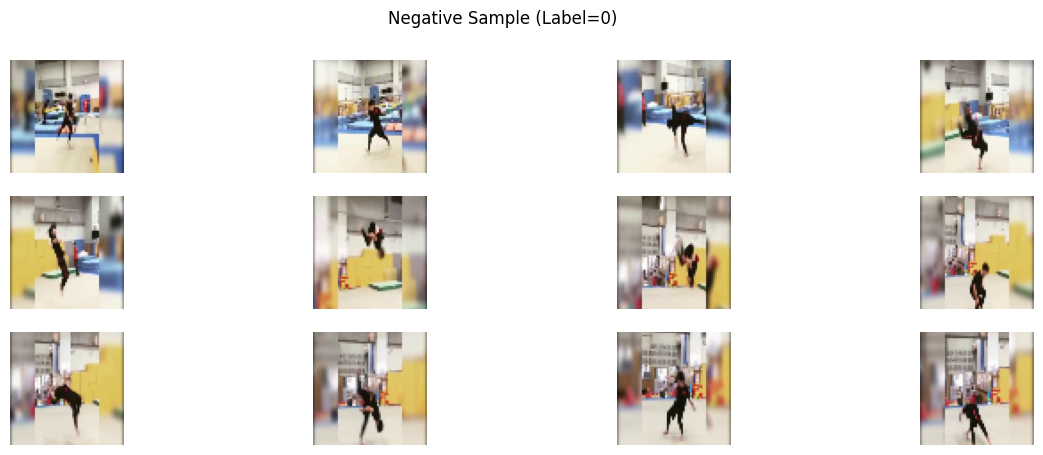

In [14]:
positive_sample = (positive_sample * 255).astype('uint8')
negative_sample = (negative_sample * 255).astype('uint8')

# Visualize the positive sample
visualize_sample(positive_sample, title='Positive Sample (Label=1)')

# Visualize the negative sample
visualize_sample(negative_sample, title='Negative Sample (Label=0)')

In [15]:

violence_val_generator = VideoDataGenerator(
    violence_val_videos,
    violence_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
)
violence_test_generator = VideoDataGenerator(
    violence_test_videos,
    violence_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
)

In [16]:
# TikTok dataset generators
tiktok_train_generator = VideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
)
tiktok_val_generator = VideoDataGenerator(
    tiktok_val_videos,
    tiktok_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
)
tiktok_test_generator = VideoDataGenerator(
    tiktok_test_videos,
    tiktok_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
)

## C3D Network as the Feature Extractor

### Baseline Classification with C3D Model

#### Load and Compile the Model

In [17]:
# Load the base C3D model
base_model_c3d = load_c3d_model(input_shape=input_shape, feature_dim=feature_dim)
print("Base C3D Model Summary:")
base_model_c3d.summary()

Base C3D Model Summary:
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 32, 32, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 6

In [18]:
# Create classification model
def create_classification_model(base_model, num_classes):
    """Create a classification model by adding a dense layer on top of base_model."""
    features = base_model.output
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [19]:
def scheduler(epoch, lr):
    # Every 3 epochs, the learning rate decays to 0.01 times the original
    if epoch % 3 == 0 and epoch > 0:
        return lr * 0.01
    return lr
    

In [20]:
# Classification model for Violence dataset
classification_model_violence = create_classification_model(base_model_c3d, num_classes)
# Freeze base model layers
for layer in classification_model_violence.layers[:-1]:
    layer.trainable = False

# Compile the model
classification_model_violence.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[metrics.SparseCategoricalAccuracy()],
)
lr_scheduler = callbacks.LearningRateScheduler(scheduler)

In [21]:
print("Classification Model for Violence Dataset Summary:")
classification_model_violence.summary()

Classification Model for Violence Dataset Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 32, 32, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_

#### Train and Evaluate on Violence Dataset

In [22]:
 # Train the model on Violence dataset
history_violence = classification_model_violence.fit(
    violence_train_generator,
    validation_data=violence_val_generator,
    epochs=num_epochs,
    callbacks=[lr_scheduler],
)

Epoch 1/10
44/44 [==============================] - 31s 598ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5142 - val_loss: 0.6928 - val_sparse_categorical_accuracy: 0.6875 - lr: 1.0000e-05
Epoch 2/10
44/44 [==============================] - 26s 594ms/step - loss: 0.6933 - sparse_categorical_accuracy: 0.5028 - val_loss: 0.6929 - val_sparse_categorical_accuracy: 0.7292 - lr: 1.0000e-05
Epoch 3/10
44/44 [==============================] - 26s 608ms/step - loss: 0.6934 - sparse_categorical_accuracy: 0.4972 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.6458 - lr: 1.0000e-05
Epoch 4/10
44/44 [==============================] - 25s 582ms/step - loss: 0.6930 - sparse_categorical_accuracy: 0.5057 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.6458 - lr: 1.0000e-07
Epoch 5/10
44/44 [==============================] - 25s 573ms/step - loss: 0.6926 - sparse_categorical_accuracy: 0.5426 - val_loss: 0.6930 - val_sparse_categorical_accuracy: 0.6458 - lr: 1.0000e-07
Epoch 6/10

In [23]:
# Evaluate on Violence test set
base_c3d_results_violence = classification_model_violence.evaluate(violence_test_generator)
print(f"Violence Dataset - Test Loss: {base_c3d_results_violence[0]:.4f}, Test Accuracy: {base_c3d_results_violence[1]:.4f}")


24/24 [==============================] - 11s 448ms/step - loss: 0.6931 - sparse_categorical_accuracy: 0.5833
Violence Dataset - Test Loss: 0.6931, Test Accuracy: 0.5833


In [24]:
# Plot training & validation accuracy and loss
def plot_history(history, title):
    """Plot training and validation accuracy and loss."""
    acc = history.history['sparse_categorical_accuracy']
    val_acc = history.history['val_sparse_categorical_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

In [ ]:
# Plot training loss
def plot_loss_history(history, title):
    """Plot training and validation accuracy and loss."""
    loss = history.history['loss']
    epochs_range = range(len(loss))

    plt.figure(figsize=(12, 6))

    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

In [ ]:
# Plot training & validation accuracy and loss
def plot_acc_history(history, title):
    """Plot training and validation accuracy and loss."""
    acc = history.history['accuracy']
    loss = history.history['loss']

    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.legend(loc='lower right')
    plt.title(f'{title} - Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.legend(loc='upper right')
    plt.title(f'{title} - Loss')
    plt.show()

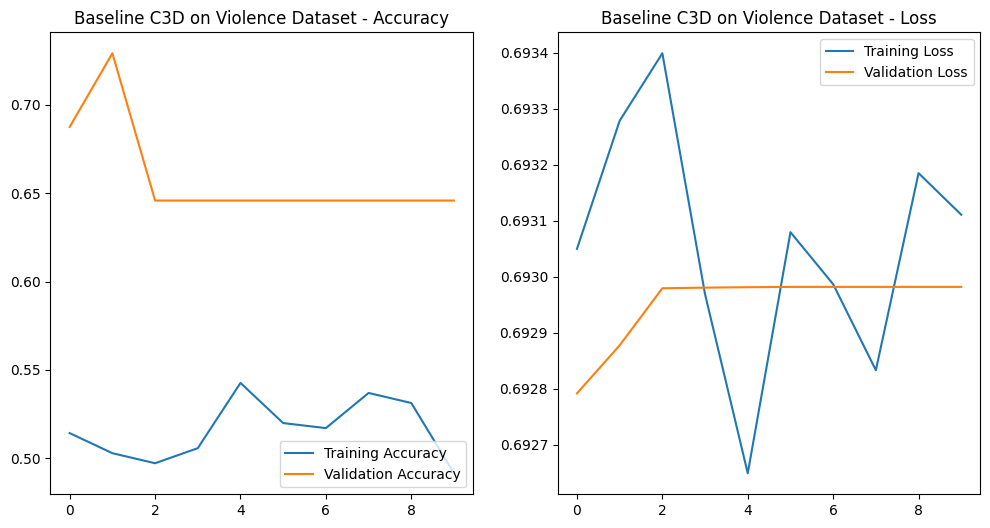

In [25]:
plot_history(history_violence, 'Baseline C3D on Violence Dataset')

In [26]:
# Display confusion matrix
def display_confusion_matrix(model, test_generator, class_names, title):
    """Display confusion matrix for the test set."""
    y_pred = model.predict(test_generator)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = test_generator.labels

    print(len(y_pred_classes), len(y_true))
    
    cm = confusion_matrix(y_true, y_pred_classes)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f'{title} - Confusion Matrix')
    plt.show()

In [27]:
print(len(violence_test_generator))

24


24/24 [==============================] - 10s 438ms/step
96 96


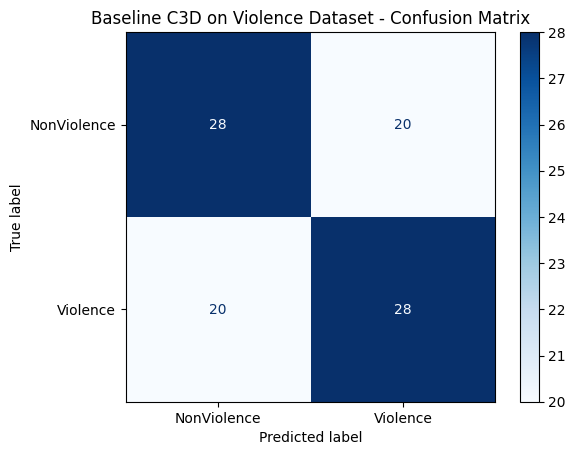

In [28]:

display_confusion_matrix(classification_model_violence, violence_test_generator, violence_class_name, 'Baseline C3D on Violence Dataset')


In [29]:
# Classification model for TikTok dataset
classification_model_tiktok = create_classification_model(base_model_c3d, num_classes)

# Freeze base model layers
for layer in classification_model_tiktok.layers[:-1]:
    layer.trainable = False

# Compile the model
classification_model_tiktok.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[metrics.SparseCategoricalAccuracy()],
)

print("Classification Model for TikTok Dataset Summary:")
classification_model_tiktok.summary()

Classification Model for TikTok Dataset Summary:
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d (Conv3D)             (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 12, 32, 32, 64)   0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_2 

In [30]:
# Train the model on TikTok dataset
history_tiktok = classification_model_tiktok.fit(
    tiktok_train_generator,
    validation_data=tiktok_val_generator,
    epochs=num_epochs,
    callbacks=[lr_scheduler],
)

Epoch 1/10
44/44 [==============================] - 76s 2s/step - loss: 0.6934 - sparse_categorical_accuracy: 0.4744 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4792 - lr: 1.0000e-05
Epoch 2/10
44/44 [==============================] - 73s 2s/step - loss: 0.6935 - sparse_categorical_accuracy: 0.4403 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4792 - lr: 1.0000e-05
Epoch 3/10
44/44 [==============================] - 73s 2s/step - loss: 0.6936 - sparse_categorical_accuracy: 0.4545 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4792 - lr: 1.0000e-05
Epoch 4/10
44/44 [==============================] - 74s 2s/step - loss: 0.6933 - sparse_categorical_accuracy: 0.4773 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4792 - lr: 1.0000e-07
Epoch 5/10
44/44 [==============================] - 73s 2s/step - loss: 0.6932 - sparse_categorical_accuracy: 0.4943 - val_loss: 0.6933 - val_sparse_categorical_accuracy: 0.4792 - lr: 1.0000e-07
Epoch 6/10
44/44 [=======

24/24 [==============================] - 31s 1s/step - loss: 0.6934 - sparse_categorical_accuracy: 0.4792
TikTok Dataset - Test Loss: 0.6934, Test Accuracy: 0.4792


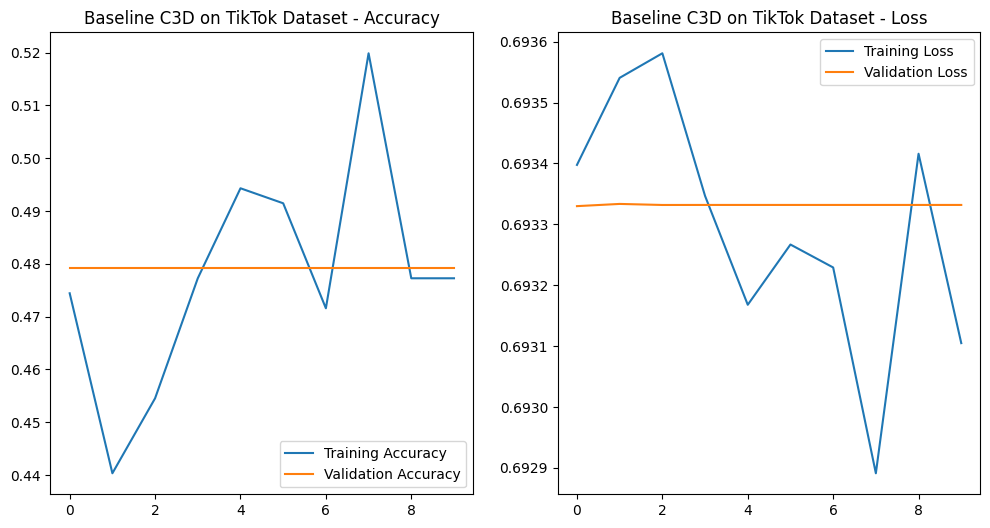

In [31]:
# Evaluate on TikTok test set
base_c3d_results_tiktok = classification_model_tiktok.evaluate(tiktok_test_generator)
print(f"TikTok Dataset - Test Loss: {base_c3d_results_tiktok[0]:.4f}, Test Accuracy: {base_c3d_results_tiktok[1]:.4f}")

plot_history(history_tiktok, 'Baseline C3D on TikTok Dataset')


24/24 [==============================] - 32s 1s/step
96 96


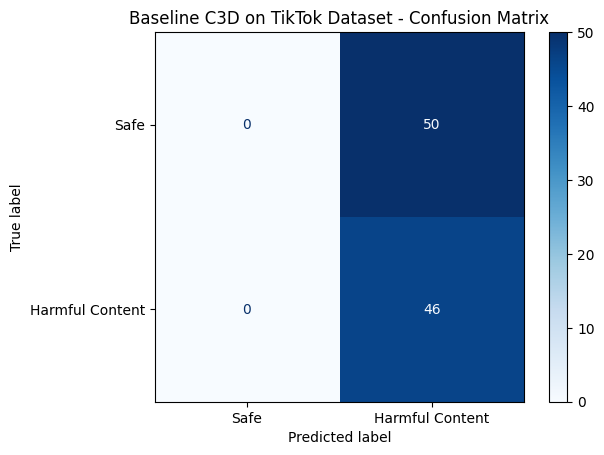

In [32]:
# Display confusion matrix
display_confusion_matrix(classification_model_tiktok, tiktok_test_generator, tiktok_class_name, 'Baseline C3D on TikTok Dataset')


### Multi-dataset Supervised Contrastive Learning (MSupCL)

#### Prepare Data for MSupCL

In [33]:
# Combine training data from both datasets
combined_train_videos = violence_train_videos + tiktok_train_videos
combined_train_labels = violence_train_labels_np.tolist() + tiktok_train_labels_np.tolist()

# Create a combined data generator
combined_train_generator = VideoDataGenerator(
    combined_train_videos,
    combined_train_labels,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
)

# Create paired data generators for MSupCL
violence_train_generator_no_aug = VideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=False,
)
tiktok_train_generator_no_aug = VideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=False,
)
paired_train_generator = MultiDatasetDataGenerator(
    violence_train_videos, violence_train_labels_np,
    tiktok_train_videos, tiktok_train_labels_np,
    batch_size=8,
    shuffle=True
)

#### Load and Train MSupCL Model

In [34]:
# Load the MSupCL model
msupcl_model = load_c3d_model(input_shape=input_shape, feature_dim=feature_dim)
print("MSupCL Model Summary:")
msupcl_model.summary()

MSupCL Model Summary:
Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d_8 (Conv3D)           (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_5 (MaxPooling  (None, 12, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_9 (Conv3D)           (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_6 (MaxPooling  (None, 6, 16, 16, 128)   0         
 3D)                                                             
                                                                 
 conv3d_10 (Conv3D)          (None, 6

In [35]:
msupcl_c3d_loss_history = train_msupcl_model(msupcl_model, paired_train_generator, epochs=num_epochs, temperature=temperature)

Epoch 1/10


Epoch 1/10: 100%|██████████| 44/44 [01:30<00:00,  2.07s/it]


Training Loss: 2.9167
Epoch 2/10


Epoch 2/10: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Training Loss: 2.9102
Epoch 3/10


Epoch 3/10: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Training Loss: 2.9048
Epoch 4/10


Epoch 4/10: 100%|██████████| 44/44 [01:26<00:00,  1.97s/it]


Training Loss: 2.9105
Epoch 5/10


Epoch 5/10: 100%|██████████| 44/44 [01:26<00:00,  1.96s/it]


Training Loss: 2.9082
Epoch 6/10


Epoch 6/10: 100%|██████████| 44/44 [01:24<00:00,  1.92s/it]


Training Loss: 2.9112
Epoch 7/10


Epoch 7/10: 100%|██████████| 44/44 [01:24<00:00,  1.91s/it]


Training Loss: 2.9142
Epoch 8/10


Epoch 8/10: 100%|██████████| 44/44 [01:26<00:00,  1.96s/it]


Training Loss: 2.9128
Epoch 9/10


Epoch 9/10: 100%|██████████| 44/44 [01:25<00:00,  1.95s/it]


Training Loss: 2.9102
Epoch 10/10


Epoch 10/10: 100%|██████████| 44/44 [01:25<00:00,  1.94s/it]

Training Loss: 2.9149


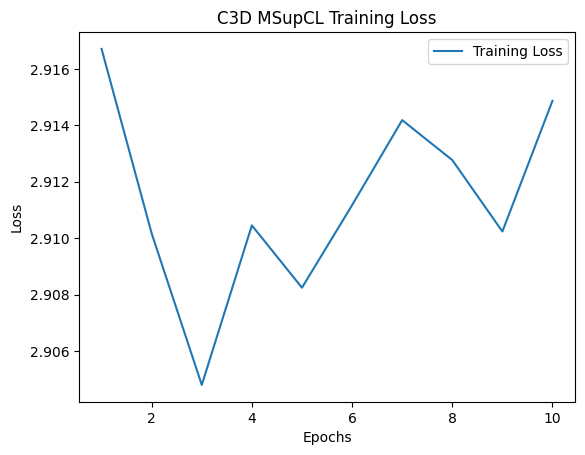

In [36]:
plt.figure()
plt.plot(range(1, len(msupcl_c3d_loss_history) + 1), msupcl_c3d_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('C3D MSupCL Training Loss')
plt.legend()
plt.show()

#### Evaluate MSupCL Model

In [37]:
# Linear evaluation on both datasets
msupcl_c3d_result_violence, msupcl_c3d_result_tiktok, msupcl_c3d_history, msupcl_c3d_classifier_model = linear_evaluation(
    msupcl_model,
    combined_train_generator,
    violence_test_generator,
    tiktok_test_generator,
    num_classes=num_classes,
)

Epoch 1/5
88/88 [==============================] - 80s 898ms/step - loss: 6.9930 - accuracy: 0.4872 - lr: 1.0000e-04
Epoch 2/5
88/88 [==============================] - 79s 889ms/step - loss: 4.4703 - accuracy: 0.4957 - lr: 1.0000e-04
Epoch 3/5
88/88 [==============================] - 80s 914ms/step - loss: 4.9656 - accuracy: 0.4830 - lr: 1.0000e-04
Epoch 4/5
88/88 [==============================] - 78s 889ms/step - loss: 4.2410 - accuracy: 0.5142 - lr: 1.0000e-06
Epoch 5/5
88/88 [==============================] - 79s 892ms/step - loss: 4.4100 - accuracy: 0.5185 - lr: 1.0000e-06
Evaluating on Violence Test Set:
24/24 [==============================] - 11s 450ms/step - loss: 2.3667 - accuracy: 0.5000
Violence Test Loss: 2.3667280673980713, Test Accuracy: 0.5
Evaluating on TikTok Test Set:
24/24 [==============================] - 31s 1s/step - loss: 2.4274 - accuracy: 0.5208
TikTok Test Loss: 2.427365779876709, Test Accuracy: 0.5208333134651184


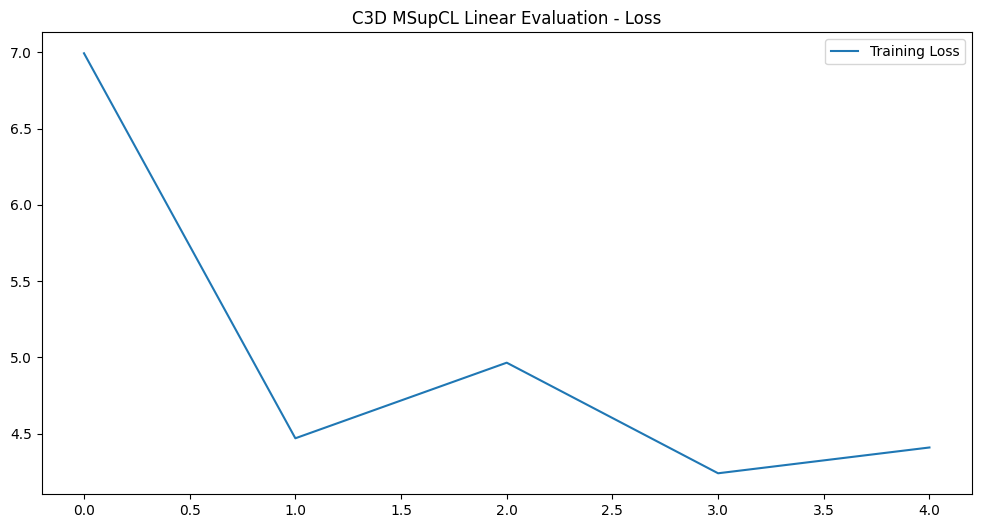

In [43]:
plot_loss_history(msupcl_c3d_history, 'C3D MSupCL Linear Evaluation')

24/24 [==============================] - 11s 470ms/step
96 96


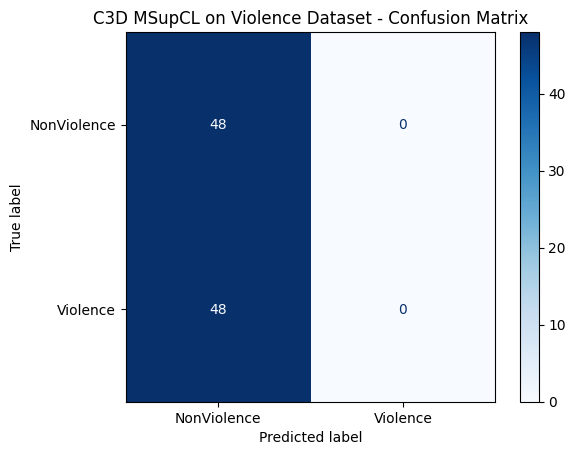

24/24 [==============================] - 32s 1s/step
96 96


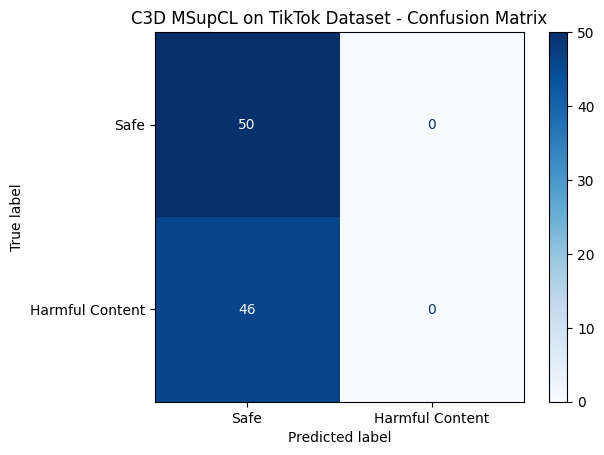

In [44]:

display_confusion_matrix(msupcl_c3d_classifier_model, violence_test_generator, violence_class_name, 'C3D MSupCL on Violence Dataset')

display_confusion_matrix(msupcl_c3d_classifier_model, tiktok_test_generator, tiktok_class_name, 'C3D MSupCL on TikTok Dataset')


### Self-Supervised Contrastive Learning (SSCL) with SimCLR

#### Prepare Data Generators for SSCL


In [45]:
# SSCL data generators for Violence dataset
violence_train_sscl_generator = SSCLVideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    double_view=True,
)
violence_train_single_sscl_generator = SSCLVideoDataGenerator(
    violence_train_videos,
    violence_train_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
violence_val_sscl_generator = SSCLVideoDataGenerator(
    violence_val_videos,
    violence_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
violence_test_sscl_generator = SSCLVideoDataGenerator(
    violence_test_videos,
    violence_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)

# SSCL data generators for TikTok dataset
tiktok_train_sscl_generator = SSCLVideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=True,
    augment=True,
    double_view=True,
)
tiktok_train_single_sscl_generator = SSCLVideoDataGenerator(
    tiktok_train_videos,
    tiktok_train_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
tiktok_val_sscl_generator = SSCLVideoDataGenerator(
    tiktok_val_videos,
    tiktok_val_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)
tiktok_test_sscl_generator = SSCLVideoDataGenerator(
    tiktok_test_videos,
    tiktok_test_labels_np,
    batch_size=batch_size,
    shuffle=False,
    augment=False,
    double_view=False,
)


#### Load and Train SSCL Model with C3D Backbone

In [46]:
# Load the SSCL model with C3D backbone
sscl_model_c3d = load_c3d_sscl_model(input_shape=input_shape, feature_dim=feature_dim)
print("SSCL Model with C3D Backbone Summary:")
sscl_model_c3d.summary()

SSCL Model with C3D Backbone Summary:
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 12, 64, 64, 3)]   0         
                                                                 
 conv3d_16 (Conv3D)          (None, 12, 64, 64, 64)    5248      
                                                                 
 max_pooling3d_10 (MaxPoolin  (None, 12, 32, 32, 64)   0         
 g3D)                                                            
                                                                 
 conv3d_17 (Conv3D)          (None, 12, 32, 32, 128)   221312    
                                                                 
 max_pooling3d_11 (MaxPoolin  (None, 6, 16, 16, 128)   0         
 g3D)                                                            
                                                                 
 conv3d_18 (Conv3D)  

In [47]:
# Train SSCL model on Violence dataset
sscl_c3d_violence_loss_history = train_simclr_model(sscl_model_c3d, violence_train_sscl_generator, epochs=num_epochs, temperature=temperature)



Epoch 1/10


Epoch 1/10: 100%|██████████| 44/44 [01:49<00:00,  2.49s/it]


Epoch 1, Loss: 1.9444
Epoch 2/10


Epoch 2/10: 100%|██████████| 44/44 [01:48<00:00,  2.47s/it]


Epoch 2, Loss: 1.9478
Epoch 3/10


Epoch 3/10: 100%|██████████| 44/44 [01:48<00:00,  2.47s/it]


Epoch 3, Loss: 1.9460
Epoch 4/10


Epoch 4/10: 100%|██████████| 44/44 [01:47<00:00,  2.45s/it]


Epoch 4, Loss: 1.9458
Epoch 5/10


Epoch 5/10: 100%|██████████| 44/44 [01:48<00:00,  2.46s/it]


Epoch 5, Loss: 1.9462
Epoch 6/10


Epoch 6/10: 100%|██████████| 44/44 [01:50<00:00,  2.52s/it]


Epoch 6, Loss: 1.9439
Epoch 7/10


Epoch 7/10: 100%|██████████| 44/44 [01:49<00:00,  2.48s/it]


Epoch 7, Loss: 1.9474
Epoch 8/10


Epoch 8/10: 100%|██████████| 44/44 [01:50<00:00,  2.50s/it]


Epoch 8, Loss: 1.9439
Epoch 9/10


Epoch 9/10: 100%|██████████| 44/44 [01:48<00:00,  2.47s/it]


Epoch 9, Loss: 1.9470
Epoch 10/10


Epoch 10/10: 100%|██████████| 44/44 [01:50<00:00,  2.52s/it]

Epoch 10, Loss: 1.9450


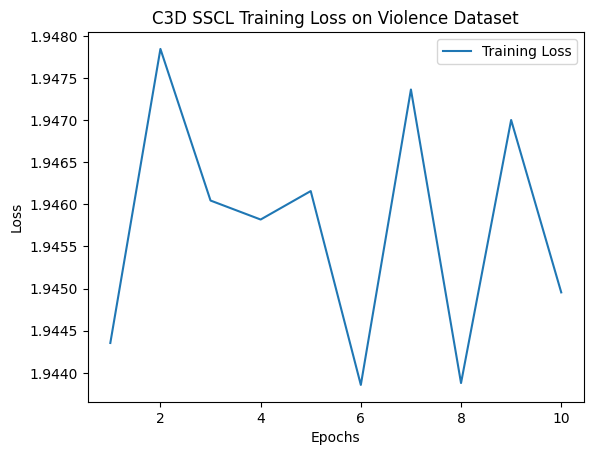

In [48]:
plt.figure()
plt.plot(range(1, len(sscl_c3d_violence_loss_history) + 1), sscl_c3d_violence_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('C3D SSCL Training Loss on Violence Dataset')
plt.legend()
plt.show()

#### Evaluate SSCL Model on Violence Dataset

In [49]:
# Linear evaluation on Violence dataset
sscl_c3d_result_violence, sscl_c3d_violence_history, sscl_c3d_violence_classifier_model = linear_evaluation_sscl(
    sscl_model_c3d,
    violence_train_single_sscl_generator,
    violence_val_sscl_generator,
    violence_test_sscl_generator,
    num_classes=num_classes,
)
print(f"SSCL C3D Violence Dataset - Test Accuracy: {sscl_c3d_result_violence[1]:.4f}")

Epoch 1/3
44/44 [==============================] - 78s 2s/step - loss: 8.5909 - accuracy: 0.4830 - val_loss: 0.8363 - val_accuracy: 0.3125 - lr: 1.0000e-04
Epoch 2/3
44/44 [==============================] - 73s 2s/step - loss: 9.9370 - accuracy: 0.4659 - val_loss: 1.2879 - val_accuracy: 0.6875 - lr: 1.0000e-04
Epoch 3/3
24/24 [==============================] - 32s 1s/step - loss: 3.0873 - accuracy: 0.5000
Test Loss: 3.0873239040374756, Test Accuracy: 0.5
SSCL C3D Violence Dataset - Test Accuracy: 0.5000


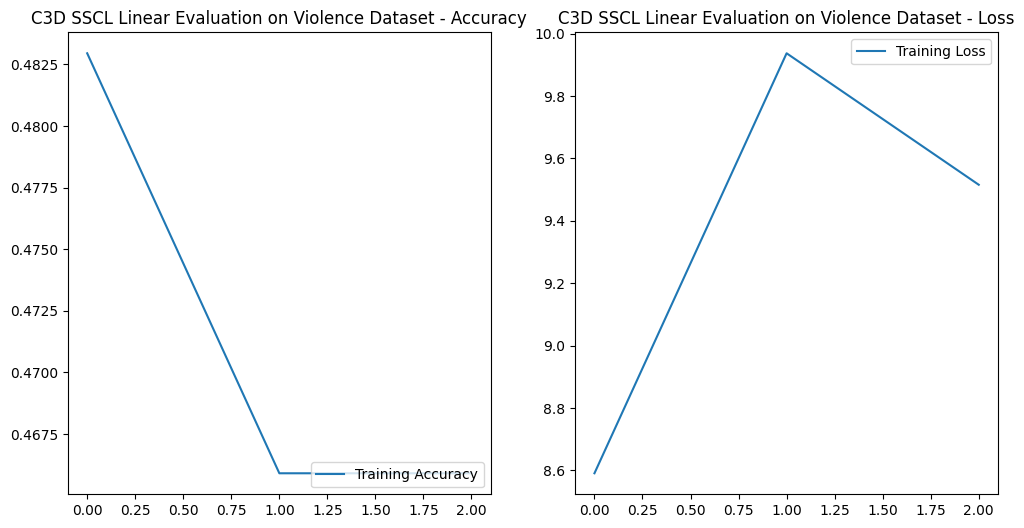

In [52]:
plot_acc_history(sscl_c3d_violence_history,'C3D SSCL Linear Evaluation on Violence Dataset')

24/24 [==============================] - 31s 1s/step
96 96


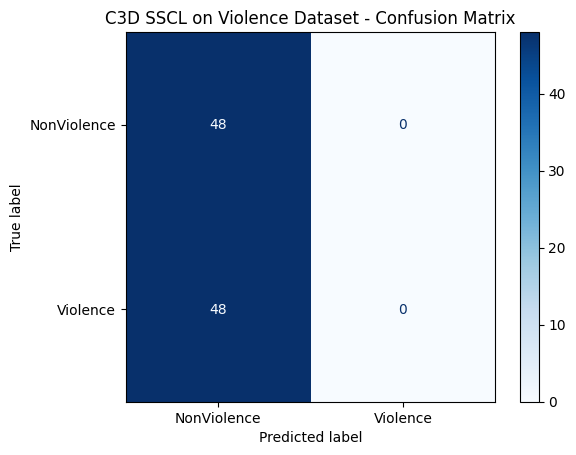

In [54]:
display_confusion_matrix(sscl_c3d_violence_classifier_model, violence_test_sscl_generator, violence_class_name, 'C3D SSCL on Violence Dataset')

#### Train and Evaluate SSCL Model on TikTok Dataset

In [55]:
# Train SSCL model on TikTok dataset
sscl_c3d_tiktok_loss_history = train_simclr_model(sscl_model_c3d, tiktok_train_sscl_generator, epochs=num_epochs, temperature=temperature)

Epoch 1/10


Epoch 1/10: 100%|██████████| 44/44 [04:23<00:00,  5.98s/it]


Epoch 1, Loss: 1.9483
Epoch 2/10


Epoch 2/10: 100%|██████████| 44/44 [04:22<00:00,  5.97s/it]


Epoch 2, Loss: 1.9461
Epoch 3/10


Epoch 3/10: 100%|██████████| 44/44 [04:23<00:00,  6.00s/it]


Epoch 3, Loss: 1.9443
Epoch 4/10


Epoch 4/10: 100%|██████████| 44/44 [04:25<00:00,  6.04s/it]


Epoch 4, Loss: 1.9465
Epoch 5/10


Epoch 5/10: 100%|██████████| 44/44 [04:25<00:00,  6.04s/it]


Epoch 5, Loss: 1.9473
Epoch 6/10


Epoch 6/10: 100%|██████████| 44/44 [04:24<00:00,  6.00s/it]


Epoch 6, Loss: 1.9449
Epoch 7/10


Epoch 7/10: 100%|██████████| 44/44 [04:25<00:00,  6.04s/it]


Epoch 7, Loss: 1.9455
Epoch 8/10


Epoch 8/10: 100%|██████████| 44/44 [04:22<00:00,  5.98s/it]


Epoch 8, Loss: 1.9448
Epoch 9/10


Epoch 9/10: 100%|██████████| 44/44 [04:24<00:00,  6.02s/it]


Epoch 9, Loss: 1.9480
Epoch 10/10


Epoch 10/10: 100%|██████████| 44/44 [04:22<00:00,  5.97s/it]

Epoch 10, Loss: 1.9452


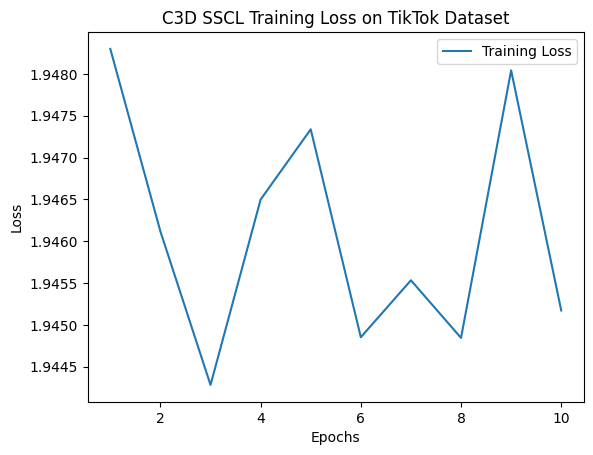

In [56]:
plt.figure()
plt.plot(range(1, len(sscl_c3d_tiktok_loss_history) + 1), sscl_c3d_tiktok_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('C3D SSCL Training Loss on TikTok Dataset')
plt.legend()
plt.show()

In [57]:

# Linear evaluation on TikTok dataset
sscl_c3d_result_tiktok, sscl_c3d_tiktok_history, sscl_c3d_tiktok_classifier_model = linear_evaluation_sscl(
    sscl_model_c3d,
    tiktok_train_single_sscl_generator,
    tiktok_val_sscl_generator,
    tiktok_test_sscl_generator,
    num_classes=num_classes,
)

print(f"C3D SSCL TikTok Dataset - Test Accuracy: {sscl_c3d_result_tiktok[1]:.4f}")


Epoch 1/3
44/44 [==============================] - 201s 5s/step - loss: 12.1831 - accuracy: 0.4148 - val_loss: 3.0614 - val_accuracy: 0.5208 - lr: 1.0000e-04
Epoch 2/3
44/44 [==============================] - 200s 5s/step - loss: 8.9366 - accuracy: 0.5511 - val_loss: 4.5653 - val_accuracy: 0.5208 - lr: 1.0000e-04
Epoch 3/3
24/24 [==============================] - 84s 4s/step - loss: 4.3690 - accuracy: 0.5208
Test Loss: 4.369035720825195, Test Accuracy: 0.5208333134651184
C3D SSCL TikTok Dataset - Test Accuracy: 0.5208


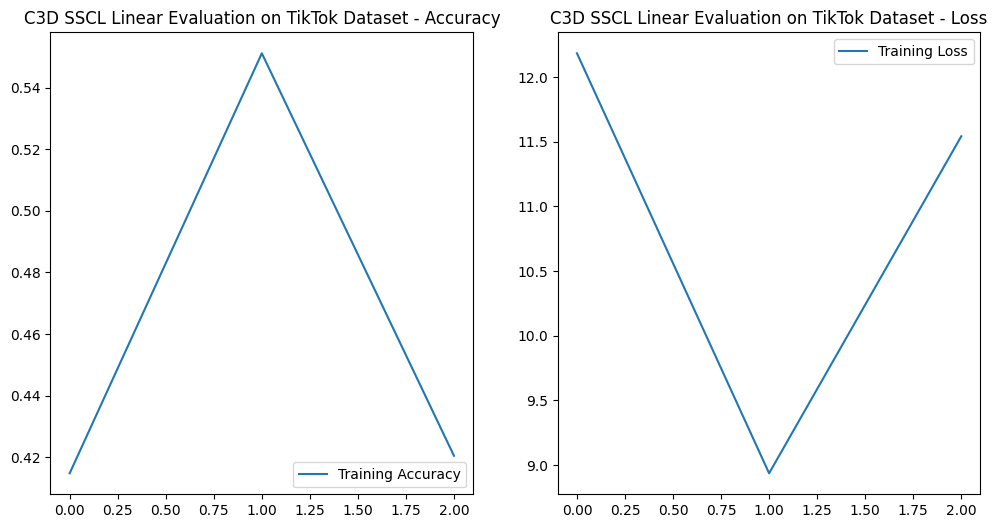

In [58]:
plot_acc_history(sscl_c3d_tiktok_history,'C3D SSCL Linear Evaluation on TikTok Dataset')

24/24 [==============================] - 84s 3s/step
96 96


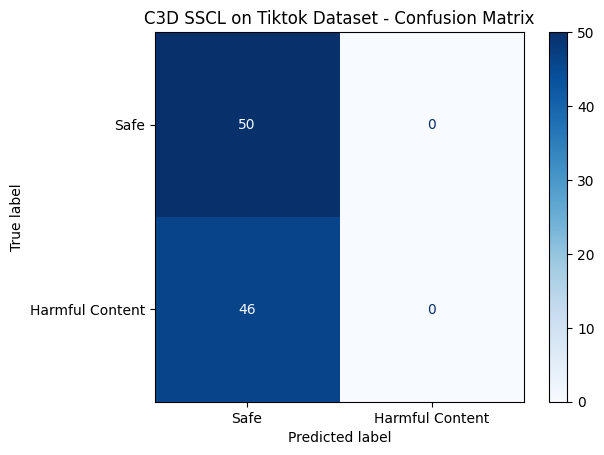

In [59]:

display_confusion_matrix(sscl_c3d_tiktok_classifier_model, tiktok_test_sscl_generator, tiktok_class_name,'C3D SSCL on Tiktok Dataset')

## R(2+1)D-18 Network as the Feature Extractor

### Baseline Classification with R(2+1)D-18 Model



In [60]:
# Load the base R(2+1)D model
base_model_r2plus1d = load_r2plus1d_model(input_shape=input_shape, feature_dim=feature_dim, include_top=False)
print("Base R(2+1)D Model Summary:")
base_model_r2plus1d.summary()

Base R(2+1)D Model Summary:
Model: "model_8"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 12, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_24 (Conv3D)             (None, 12, 32, 32,   9408        ['input_4[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization (BatchNorm  (None, 12, 32, 32,   256        ['conv3d_24[0][0]']              
 alization)                     64)                             

In [61]:
# Create classification model
def create_classification_model_r2p1d(base_model, num_classes):
    """Create a classification model by adding a dense layer on top of base_model."""
    features = base_model.output
    outputs = layers.Dense(num_classes, activation='softmax')(features)
    model = models.Model(inputs=base_model.input, outputs=outputs)
    return model

In [62]:
classification_model_r2p1d = create_classification_model_r2p1d(base_model_r2plus1d, num_classes)

# Freeze base model layers
for layer in classification_model_r2p1d.layers[:-1]:
    layer.trainable = False

# Compile the model
classification_model_r2p1d.compile(
    loss=losses.SparseCategoricalCrossentropy(),
    optimizer=optimizers.Adam(learning_rate=learning_rate),
    metrics=[metrics.SparseCategoricalAccuracy()]
)

#### Train and Evaluate on Violence Dataset

In [63]:
# Train the model on Violence dataset
history_violence_r2p1d = classification_model_r2p1d.fit(
    violence_train_generator,
    validation_data=violence_val_generator,
    epochs=num_epochs
)

Epoch 1/10
44/44 [==============================] - 27s 591ms/step - loss: 0.6981 - sparse_categorical_accuracy: 0.4489 - val_loss: 0.6850 - val_sparse_categorical_accuracy: 0.6875
Epoch 2/10
44/44 [==============================] - 26s 580ms/step - loss: 0.6977 - sparse_categorical_accuracy: 0.4489 - val_loss: 0.6854 - val_sparse_categorical_accuracy: 0.6875
Epoch 3/10
44/44 [==============================] - 25s 576ms/step - loss: 0.6974 - sparse_categorical_accuracy: 0.4489 - val_loss: 0.6857 - val_sparse_categorical_accuracy: 0.6875
Epoch 4/10
44/44 [==============================] - 25s 564ms/step - loss: 0.6973 - sparse_categorical_accuracy: 0.4489 - val_loss: 0.6862 - val_sparse_categorical_accuracy: 0.6875
Epoch 5/10
44/44 [==============================] - 25s 556ms/step - loss: 0.6970 - sparse_categorical_accuracy: 0.4489 - val_loss: 0.6866 - val_sparse_categorical_accuracy: 0.6875
Epoch 6/10
44/44 [==============================] - 25s 565ms/step - loss: 0.6968 - sparse_cate

24/24 [==============================] - 11s 451ms/step - loss: 0.6935 - sparse_categorical_accuracy: 0.5000
R(2+1)D Violence Dataset - Test Loss: 0.6935, Test Accuracy: 0.5000


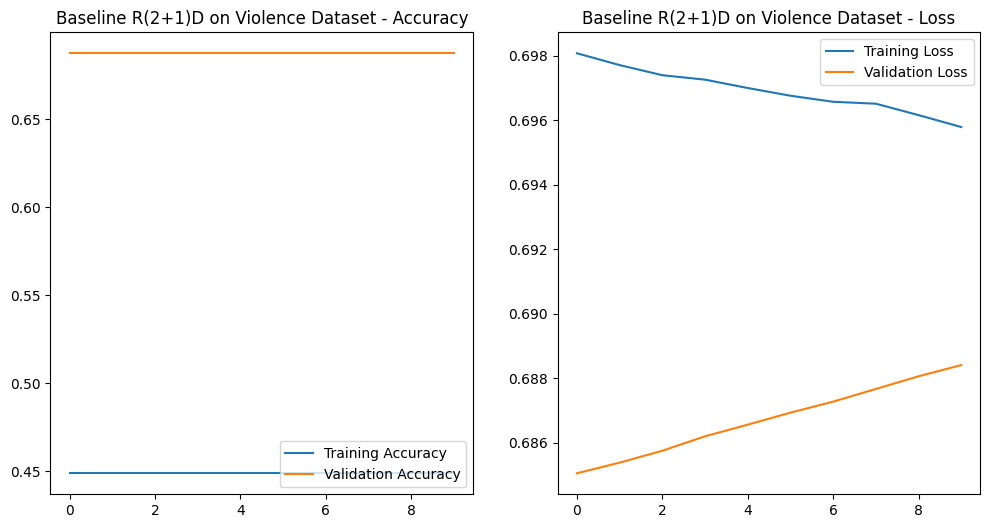

24/24 [==============================] - 11s 446ms/step
96 96


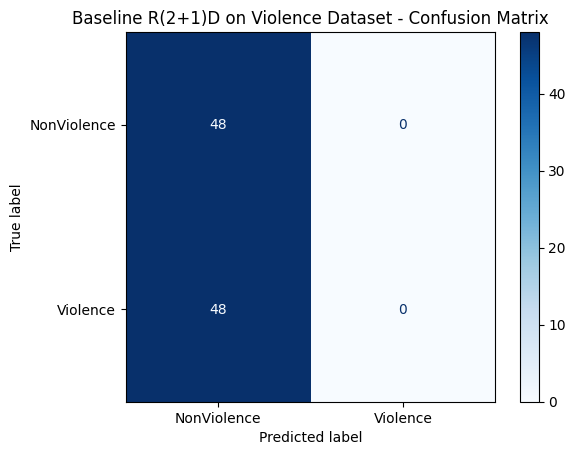

In [64]:
# Evaluate on Violence test set
base_r2plus1d_results_violence = classification_model_r2p1d.evaluate(violence_test_generator)
print(f"R(2+1)D Violence Dataset - Test Loss: {base_r2plus1d_results_violence[0]:.4f}, Test Accuracy: {base_r2plus1d_results_violence[1]:.4f}")

plot_history(history_violence_r2p1d, 'Baseline R(2+1)D on Violence Dataset')

# Display confusion matrix
display_confusion_matrix(classification_model_r2p1d, violence_test_generator, violence_class_name, 'Baseline R(2+1)D on Violence Dataset')


#### Train and Evaluate on TikTok Dataset

In [65]:
# Train the model on TikTok dataset
history_tiktok_r2p1d = classification_model_r2p1d.fit(
    tiktok_train_generator,
    validation_data=tiktok_val_generator,
    epochs=num_epochs
)

Epoch 1/10
44/44 [==============================] - 75s 2s/step - loss: 0.6922 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5208
Epoch 2/10
44/44 [==============================] - 73s 2s/step - loss: 0.6922 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5208
Epoch 3/10
44/44 [==============================] - 73s 2s/step - loss: 0.6922 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.6921 - val_sparse_categorical_accuracy: 0.5208
Epoch 4/10
44/44 [==============================] - 74s 2s/step - loss: 0.6921 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.5208
Epoch 5/10
44/44 [==============================] - 73s 2s/step - loss: 0.6922 - sparse_categorical_accuracy: 0.4830 - val_loss: 0.6920 - val_sparse_categorical_accuracy: 0.5208
Epoch 6/10
44/44 [==============================] - 74s 2s/step - loss: 0.6922 - sparse_categorical_accuracy: 

24/24 [==============================] - 31s 1s/step - loss: 0.6920 - sparse_categorical_accuracy: 0.5208
R(2+1)D TikTok Dataset - Test Loss: 0.6920, Test Accuracy: 0.5208


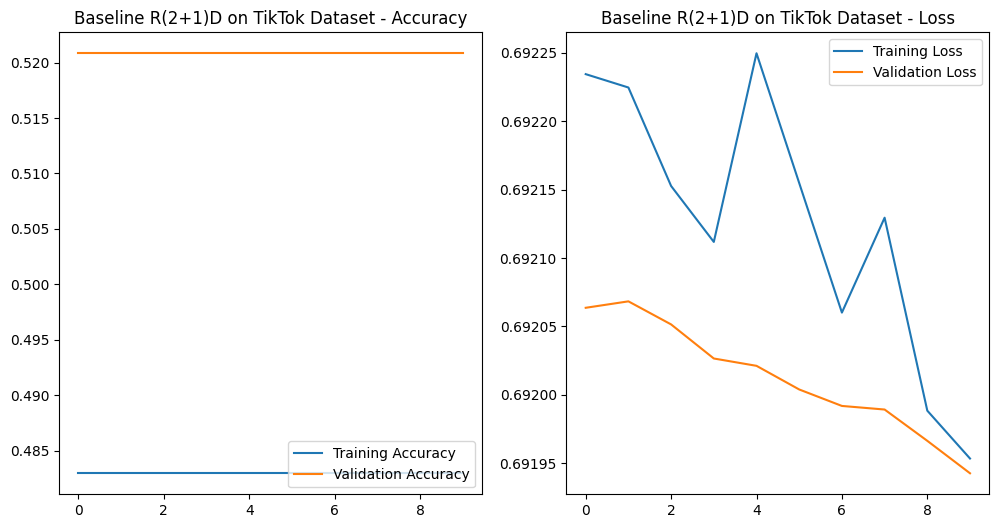

24/24 [==============================] - 32s 1s/step
96 96


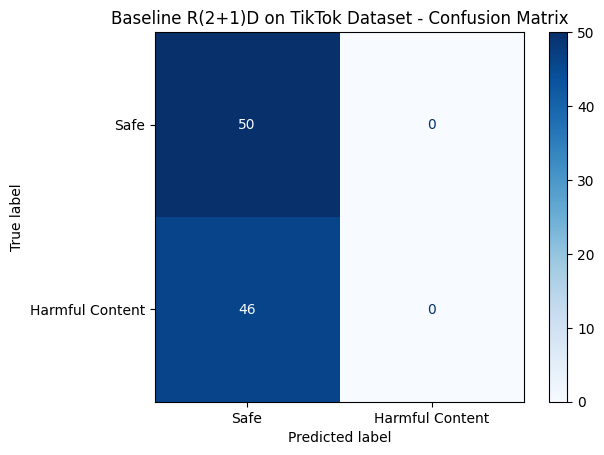

In [66]:
# Evaluate on TikTok test set
base_r2plus1d_results_tiktok = classification_model_r2p1d.evaluate(tiktok_test_generator)
print(f"R(2+1)D TikTok Dataset - Test Loss: {base_r2plus1d_results_tiktok[0]:.4f}, Test Accuracy: {base_r2plus1d_results_tiktok[1]:.4f}")

plot_history(history_tiktok_r2p1d, 'Baseline R(2+1)D on TikTok Dataset')

# Display confusion matrix
display_confusion_matrix(classification_model_r2p1d, tiktok_test_generator, tiktok_class_name, 'Baseline R(2+1)D on TikTok Dataset')


### MSupCL with R(2+1)D-18 Model

In [67]:
# Load the MSupCL model with R(2+1)D backbone
msupcl_model_r2p1d = load_r2plus1d_model(input_shape=input_shape, feature_dim=feature_dim, include_top=False)
print("MSupCL Model with R(2+1)D Backbone Summary:")
msupcl_model_r2p1d.summary()


MSupCL Model with R(2+1)D Backbone Summary:
Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 12, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_60 (Conv3D)             (None, 12, 32, 32,   9408        ['input_5[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_36 (BatchN  (None, 12, 32, 32,   256        ['conv3d_60[0][0]']              
 ormalization)                  64)            

In [68]:
# Train MSupCL model
msupcl_r2plus1d_loss_history = train_msupcl_model(msupcl_model_r2p1d, paired_train_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/10


Epoch 1/10: 100%|██████████| 44/44 [01:29<00:00,  2.03s/it]


Training Loss: 2.9333
Epoch 2/10


Epoch 2/10: 100%|██████████| 44/44 [01:27<00:00,  1.99s/it]


Training Loss: 2.8671
Epoch 3/10


Epoch 3/10: 100%|██████████| 44/44 [01:28<00:00,  2.01s/it]


Training Loss: 2.7734
Epoch 4/10


Epoch 4/10: 100%|██████████| 44/44 [01:27<00:00,  1.98s/it]


Training Loss: 2.7154
Epoch 5/10


Epoch 5/10: 100%|██████████| 44/44 [01:24<00:00,  1.92s/it]


Training Loss: 2.6947
Epoch 6/10


Epoch 6/10: 100%|██████████| 44/44 [01:24<00:00,  1.93s/it]


Training Loss: 2.6355
Epoch 7/10


Epoch 7/10: 100%|██████████| 44/44 [01:25<00:00,  1.95s/it]


Training Loss: 2.6398
Epoch 8/10


Epoch 8/10: 100%|██████████| 44/44 [01:25<00:00,  1.94s/it]


Training Loss: 2.6049
Epoch 9/10


Epoch 9/10: 100%|██████████| 44/44 [01:25<00:00,  1.94s/it]


Training Loss: 2.6474
Epoch 10/10


Epoch 10/10: 100%|██████████| 44/44 [01:26<00:00,  1.96s/it]

Training Loss: 2.5772


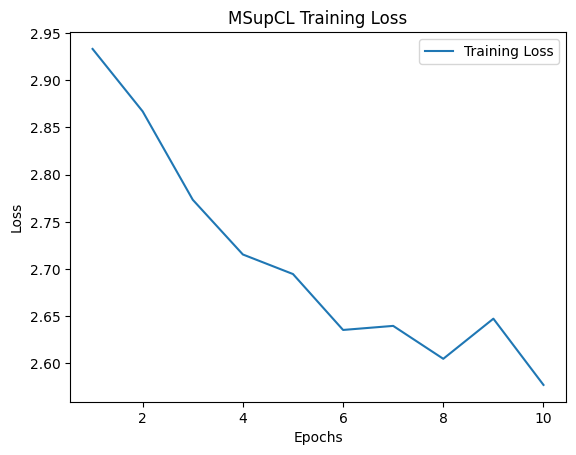

In [69]:

plt.figure()
plt.plot(range(1, len(msupcl_r2plus1d_loss_history) + 1), msupcl_r2plus1d_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('MSupCL Training Loss')
plt.legend()
plt.show()

In [70]:
# Linear evaluation on both datasets
msupcl_r2p1d_result_violence, msupcl_r2p1d_result_tiktok,msupcl_r2p1d_history, msupcl_r2p1d_classifier_model  = linear_evaluation(
    msupcl_model_r2p1d,
    combined_train_generator,
    violence_test_generator,
    tiktok_test_generator,
    num_classes=num_classes,
)



Epoch 1/5
88/88 [==============================] - 79s 882ms/step - loss: 0.7098 - accuracy: 0.4602 - lr: 1.0000e-04
Epoch 2/5
88/88 [==============================] - 78s 894ms/step - loss: 0.7049 - accuracy: 0.4631 - lr: 1.0000e-04
Epoch 3/5
88/88 [==============================] - 78s 889ms/step - loss: 0.7001 - accuracy: 0.4730 - lr: 1.0000e-04
Epoch 4/5
88/88 [==============================] - 78s 884ms/step - loss: 0.6956 - accuracy: 0.5014 - lr: 1.0000e-06
Epoch 5/5
88/88 [==============================] - 79s 895ms/step - loss: 0.6957 - accuracy: 0.5057 - lr: 1.0000e-06
Evaluating on Violence Test Set:
24/24 [==============================] - 11s 446ms/step - loss: 0.7026 - accuracy: 0.4479
Violence Test Loss: 0.7026188969612122, Test Accuracy: 0.4479166567325592
Evaluating on TikTok Test Set:
24/24 [==============================] - 31s 1s/step - loss: 0.7071 - accuracy: 0.4792
TikTok Test Loss: 0.7070703506469727, Test Accuracy: 0.4791666567325592


24/24 [==============================] - 11s 449ms/step
96 96


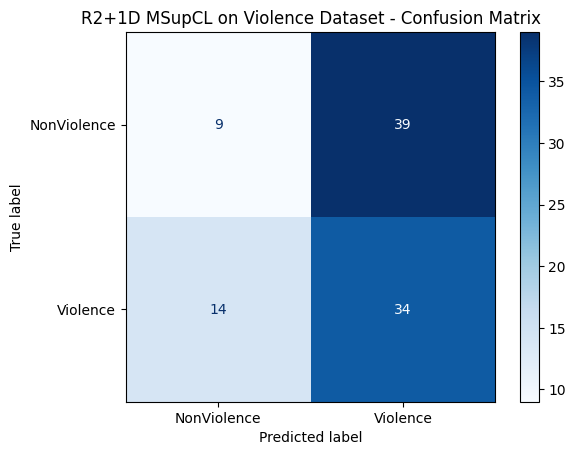

24/24 [==============================] - 31s 1s/step
96 96


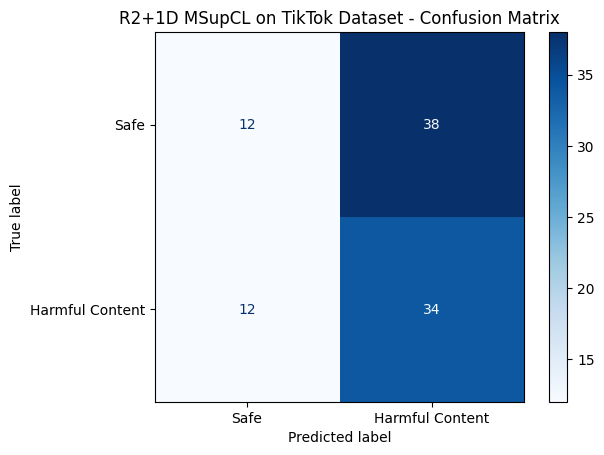

In [71]:
display_confusion_matrix(msupcl_r2p1d_classifier_model, violence_test_generator, violence_class_name, 'R2+1D MSupCL on Violence Dataset')

display_confusion_matrix(msupcl_r2p1d_classifier_model, tiktok_test_generator, tiktok_class_name, 'R2+1D MSupCL on TikTok Dataset')

### SSCL with R(2+1)D-18 Model

In [72]:
# Load the SSCL model with R(2+1)D backbone
sscl_model_r2p1d = load_sscl_r2plus1d_model(input_shape=input_shape, feature_dim=feature_dim)
print("SSCL Model with R(2+1)D Backbone Summary:")
sscl_model_r2p1d.summary()

SSCL Model with R(2+1)D Backbone Summary:
Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 12, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv3d_96 (Conv3D)             (None, 12, 32, 32,   9408        ['input_6[0][0]']                
                                64)                                                               
                                                                                                  
 batch_normalization_72 (BatchN  (None, 12, 32, 32,   256        ['conv3d_96[0][0]']              
 ormalization)                  64)              

In [73]:
# Train SSCL model on Violence dataset
sscl_r2p1d_violence_loss_history =train_simclr_model(sscl_model_r2p1d, violence_train_sscl_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/10


Epoch 1/10: 100%|██████████| 44/44 [01:48<00:00,  2.47s/it]


Epoch 1, Loss: 1.5793
Epoch 2/10


Epoch 2/10: 100%|██████████| 44/44 [01:49<00:00,  2.48s/it]


Epoch 2, Loss: 1.2852
Epoch 3/10


Epoch 3/10: 100%|██████████| 44/44 [01:49<00:00,  2.49s/it]


Epoch 3, Loss: 1.1425
Epoch 4/10


Epoch 4/10: 100%|██████████| 44/44 [01:49<00:00,  2.48s/it]


Epoch 4, Loss: 1.0281
Epoch 5/10


Epoch 5/10: 100%|██████████| 44/44 [01:51<00:00,  2.53s/it]


Epoch 5, Loss: 0.9897
Epoch 6/10


Epoch 6/10: 100%|██████████| 44/44 [01:52<00:00,  2.55s/it]


Epoch 6, Loss: 0.9282
Epoch 7/10


Epoch 7/10: 100%|██████████| 44/44 [01:51<00:00,  2.54s/it]


Epoch 7, Loss: 0.8829
Epoch 8/10


Epoch 8/10: 100%|██████████| 44/44 [01:51<00:00,  2.54s/it]


Epoch 8, Loss: 0.8856
Epoch 9/10


Epoch 9/10: 100%|██████████| 44/44 [01:48<00:00,  2.45s/it]


Epoch 9, Loss: 0.8530
Epoch 10/10


Epoch 10/10: 100%|██████████| 44/44 [01:49<00:00,  2.49s/it]

Epoch 10, Loss: 0.8402


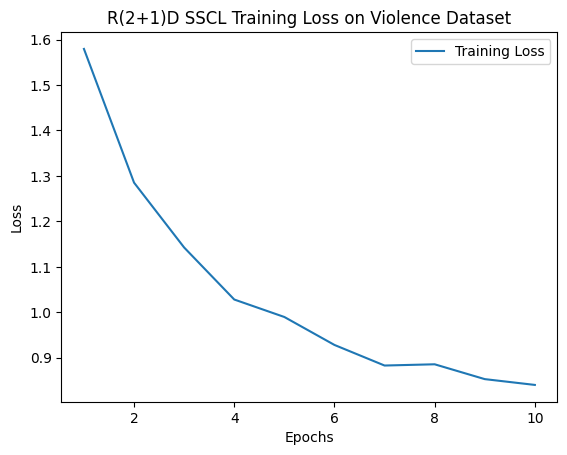

In [74]:
plt.figure()
plt.plot(range(1, len(sscl_r2p1d_violence_loss_history) + 1), sscl_r2p1d_violence_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('R(2+1)D SSCL Training Loss on Violence Dataset')
plt.legend()
plt.show()

In [75]:
# Linear evaluation on Violence dataset
sscl_r2p1d_result_violence, sscl_r2p1d_violence_history, sscl_r2p1d_violence_classifier_model  = linear_evaluation_sscl(
    sscl_model_r2p1d,
    violence_train_single_sscl_generator,
    violence_val_sscl_generator,
    violence_test_sscl_generator,
    num_classes=num_classes,
)

print(f"R(2+1)D SSCL Violence Dataset - Test Accuracy: {sscl_r2p1d_result_violence[1]:.4f}")


Epoch 1/3
44/44 [==============================] - 76s 2s/step - loss: 0.7264 - accuracy: 0.5625 - val_loss: 0.7236 - val_accuracy: 0.4583 - lr: 1.0000e-04
Epoch 2/3
44/44 [==============================] - 73s 2s/step - loss: 0.6806 - accuracy: 0.5455 - val_loss: 0.6907 - val_accuracy: 0.5625 - lr: 1.0000e-04
Epoch 3/3
24/24 [==============================] - 31s 1s/step - loss: 0.6516 - accuracy: 0.5833
Test Loss: 0.6516087651252747, Test Accuracy: 0.5833333134651184
R(2+1)D SSCL Violence Dataset - Test Accuracy: 0.5833


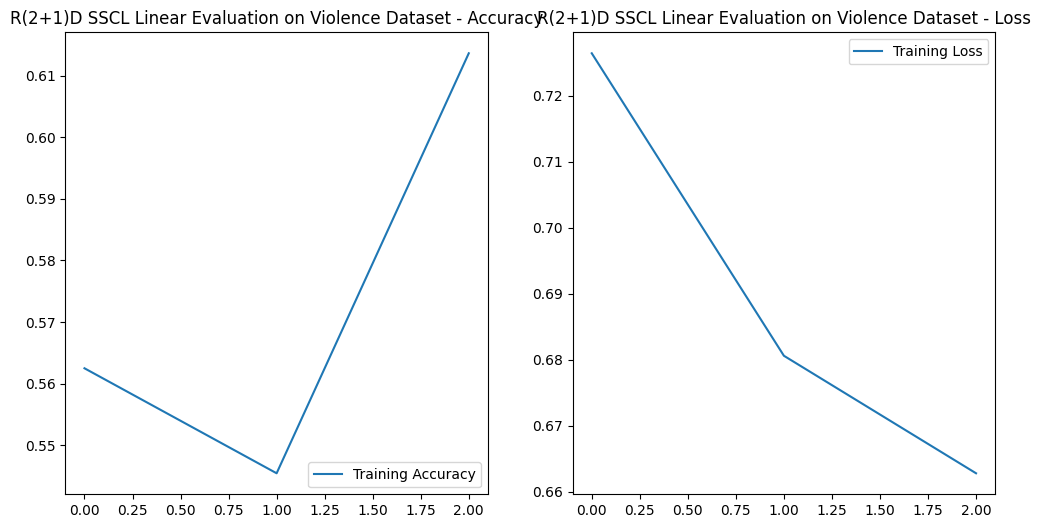

In [76]:
plot_acc_history(sscl_r2p1d_violence_history,'R(2+1)D SSCL Linear Evaluation on Violence Dataset')

24/24 [==============================] - 32s 1s/step
96 96


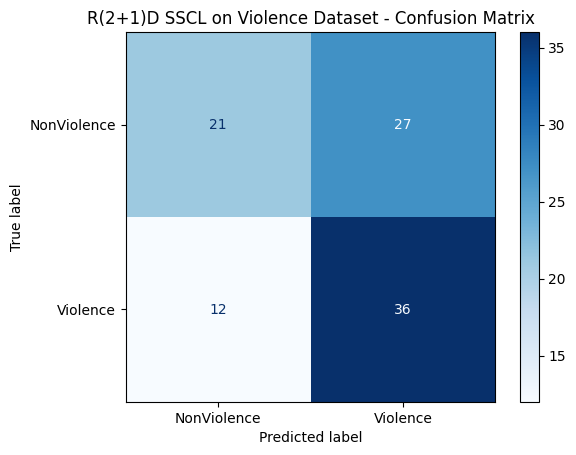

In [77]:
display_confusion_matrix(sscl_r2p1d_violence_classifier_model, violence_test_sscl_generator, violence_class_name, 'R(2+1)D SSCL on Violence Dataset')

#### Train and Evaluate SSCL Model on TikTok Dataset

In [78]:
# Train SSCL model on TikTok dataset
sscl_r2p1d_tiktok_loss_history = train_simclr_model(sscl_model_r2p1d, tiktok_train_sscl_generator, epochs=num_epochs, temperature=temperature)


Epoch 1/10


Epoch 1/10: 100%|██████████| 44/44 [04:19<00:00,  5.91s/it]


Epoch 1, Loss: 1.3432
Epoch 2/10


Epoch 2/10: 100%|██████████| 44/44 [04:18<00:00,  5.87s/it]


Epoch 2, Loss: 1.2897
Epoch 3/10


Epoch 3/10: 100%|██████████| 44/44 [04:17<00:00,  5.86s/it]


Epoch 3, Loss: 1.3099
Epoch 4/10


Epoch 4/10: 100%|██████████| 44/44 [04:18<00:00,  5.87s/it]


Epoch 4, Loss: 1.3197
Epoch 5/10


Epoch 5/10: 100%|██████████| 44/44 [04:18<00:00,  5.88s/it]


Epoch 5, Loss: 1.2869
Epoch 6/10


Epoch 6/10: 100%|██████████| 44/44 [04:19<00:00,  5.89s/it]


Epoch 6, Loss: 1.2499
Epoch 7/10


Epoch 7/10: 100%|██████████| 44/44 [04:18<00:00,  5.88s/it]


Epoch 7, Loss: 1.3159
Epoch 8/10


Epoch 8/10: 100%|██████████| 44/44 [04:20<00:00,  5.91s/it]


Epoch 8, Loss: 1.3257
Epoch 9/10


Epoch 9/10: 100%|██████████| 44/44 [04:18<00:00,  5.88s/it]


Epoch 9, Loss: 1.2877
Epoch 10/10


Epoch 10/10: 100%|██████████| 44/44 [04:19<00:00,  5.91s/it]

Epoch 10, Loss: 1.3255


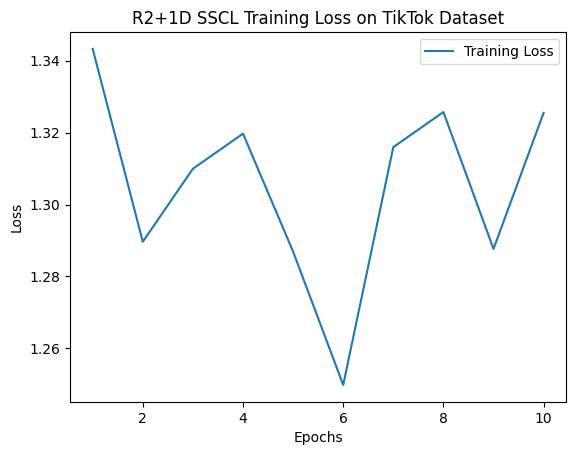

In [79]:
plt.figure()
plt.plot(range(1, len(sscl_r2p1d_tiktok_loss_history) + 1), sscl_r2p1d_tiktok_loss_history, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('R2+1D SSCL Training Loss on TikTok Dataset')
plt.legend()
plt.show()

In [80]:
# Linear evaluation on TikTok dataset
sscl_r2p1d_result_tiktok, sscl_r2p1d_tiktok_history, sscl_r2p1d_tiktok_classifier_model  = linear_evaluation_sscl(
    sscl_model_r2p1d,
    tiktok_train_single_sscl_generator,
    tiktok_val_sscl_generator,
    tiktok_test_sscl_generator,
    num_classes=num_classes,
)

print(f"SSCL R(2+1)D TikTok Dataset - Test Accuracy: {sscl_r2p1d_result_tiktok[1]:.4f}")


Epoch 1/3
44/44 [==============================] - 200s 5s/step - loss: 1.2250 - accuracy: 0.5114 - val_loss: 1.0481 - val_accuracy: 0.5000 - lr: 1.0000e-04
Epoch 2/3
44/44 [==============================] - 196s 4s/step - loss: 0.8855 - accuracy: 0.4943 - val_loss: 0.9016 - val_accuracy: 0.4375 - lr: 1.0000e-04
Epoch 3/3
24/24 [==============================] - 85s 4s/step - loss: 0.7522 - accuracy: 0.5521
Test Loss: 0.7521822452545166, Test Accuracy: 0.5520833134651184
SSCL R(2+1)D TikTok Dataset - Test Accuracy: 0.5521


24/24 [==============================] - 85s 4s/step
96 96


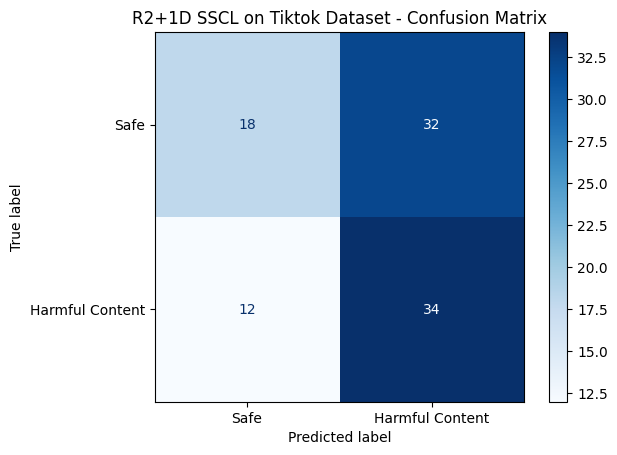

In [81]:
display_confusion_matrix(sscl_r2p1d_tiktok_classifier_model, tiktok_test_sscl_generator, tiktok_class_name,'R2+1D SSCL on Tiktok Dataset')

## Summary of Results

In [82]:
# Create a summary table of results
import pandas as pd

results = {
    'Model': ['Baseline C3D', 'MSupCL C3D', 'SSCL C3D', 'Baseline R(2+1)D', 'MSupCL R(2+1)D', 'SSCL R(2+1)D'],
    'Violence Accuracy': [
        base_c3d_results_violence[1],
        msupcl_c3d_result_violence[1],
        sscl_c3d_result_violence[1],
        base_r2plus1d_results_violence[1],
        msupcl_r2p1d_result_violence[1],
        sscl_r2p1d_result_violence[1],
    ],
    'TikTok Accuracy': [
        base_c3d_results_tiktok[1],
        msupcl_c3d_result_tiktok[1],
        sscl_c3d_result_tiktok[1],
        base_r2plus1d_results_tiktok[1],
        msupcl_r2p1d_result_tiktok[1],
        sscl_r2p1d_result_tiktok[1],
    ]
}

results_df = pd.DataFrame(results)
print(results_df)

              Model  Violence Accuracy  TikTok Accuracy
0      Baseline C3D           0.583333         0.479167
1        MSupCL C3D           0.500000         0.520833
2          SSCL C3D           0.500000         0.520833
3  Baseline R(2+1)D           0.500000         0.520833
4    MSupCL R(2+1)D           0.447917         0.479167
5      SSCL R(2+1)D           0.583333         0.552083


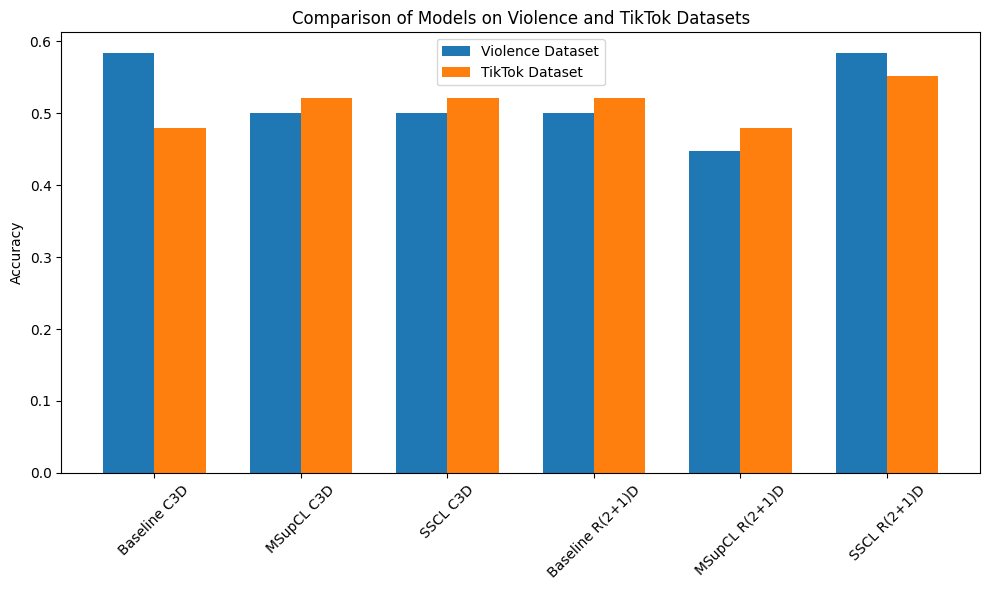

In [83]:
# Plot the accuracies
plt.figure(figsize=(10, 6))
x = np.arange(len(results_df['Model']))
width = 0.35

plt.bar(x - width/2, results_df['Violence Accuracy'], width, label='Violence Dataset')
plt.bar(x + width/2, results_df['TikTok Accuracy'], width, label='TikTok Dataset')

plt.ylabel('Accuracy')
plt.title('Comparison of Models on Violence and TikTok Datasets')
plt.xticks(x, results_df['Model'], rotation=45)
plt.legend()
plt.tight_layout()
plt.show()